### The goal of this notebook is to explore the ERA5 200 hPa data and process it into a more usable form for a CNN

In [122]:
#imports go here
import os
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [4]:
#navigate to the data and open it up
data_dir = '/Users/justinhudson/Documents/HW/ATS_780/Homework_2/DATA'
os.chdir(data_dir)
e5data = Dataset('ERA5_200hpa_U_V_relVort_Colorado_2021_2022.nc')
u = e5data.variables['u'][:]
v = e5data.variables['v'][:]
vort = e5data.variables['vo'][:]
lats = e5data.variables['latitude'][:]
lons = e5data.variables['longitude'][:]
time = e5data.variables['time'][:]
#convert times to usable dates
ref_date = dt.datetime(1900,1,1)
dates = np.array( [ ref_date + dt.timedelta(hours = int(t)) for t in time ] )

In [43]:
e5data.variables['vo']

<class 'netCDF4._netCDF4.Variable'>
int16 vo(time, latitude, longitude)
    scale_factor: 1.3644576345326389e-08
    add_offset: 2.6087090022725642e-05
    _FillValue: -32767
    missing_value: -32767
    units: s**-1
    long_name: Vorticity (relative)
    standard_name: atmosphere_relative_vorticity
unlimited dimensions: 
current shape = (17520, 25, 41)
filling on

In [163]:
def normalize_data(dataset:np.ndarray) -> np.ndarray:
    '''
        Normalizes data so that it is on the range 0-1 and then returns
        the normalized data.

        Inputs:
            dataset (np.ndarray): The dataset to be normalized
        
        Outputs:
            norm_data (np.ndarray): The normalized data
    '''

    data_min = np.nanmin(dataset)
    data_max = np.nanmax(dataset)

    norm_data = (dataset[:] - data_min) / (data_max - data_min)

    return norm_data

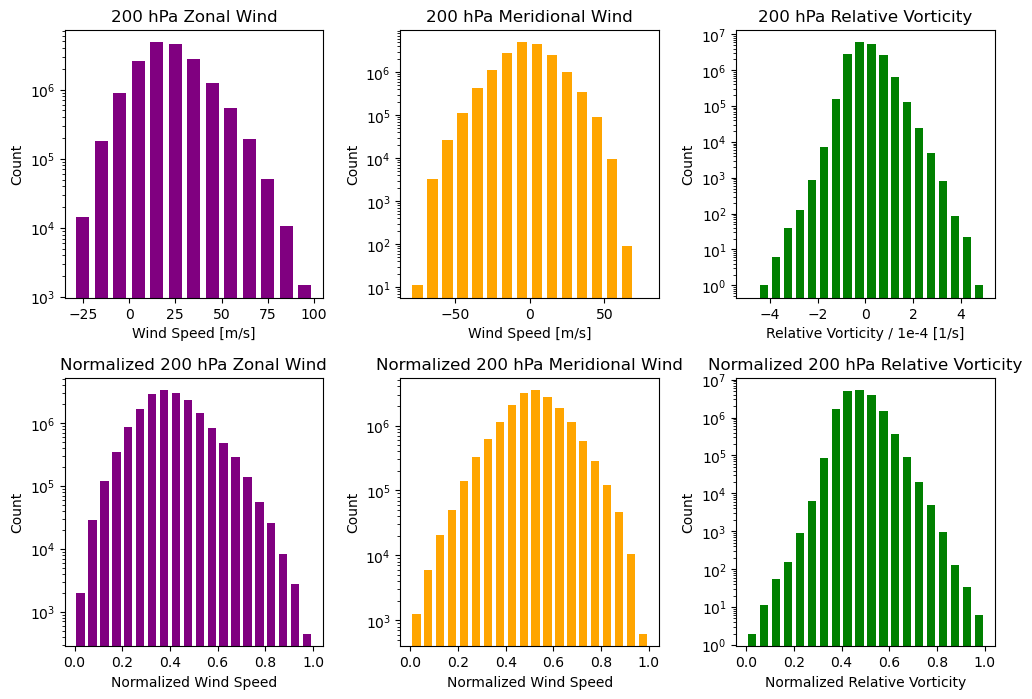

In [166]:
#let's make histograms of the data
fig,ax = plt.subplots(2,3,figsize = (12,8))

ax[0,0].hist(u.flatten(),bins = np.arange(-30,107,10),rwidth = 0.7,color = 'purple')
ax[0,0].set_title('200 hPa Zonal Wind')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('Wind Speed [m/s]')

ax[0,1].hist(v.flatten(), bins = np.arange(-80,82,10),rwidth = 0.7,color = 'orange')
ax[0,1].set_title('200 hPa Meridional Wind')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('Wind Speed [m/s]')

ax[0,2].hist(vort.flatten() / 1e-4,bins = np.arange(-5,5.1,.5),rwidth = 0.7,color = 'green')
ax[0,2].set_title('200 hPa Relative Vorticity')
ax[0,2].set_yscale('log')
ax[0,2].set_xlabel('Relative Vorticity / 1e-4 [1/s]')

#normalized data
ax[1,0].hist(normalize_data(u.flatten()),bins = np.arange(0,1.04,.05),rwidth = 0.7,color = 'purple')
ax[1,0].set_title('Normalized 200 hPa Zonal Wind')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('Normalized Wind Speed')

ax[1,1].hist(normalize_data(v.flatten()), bins = np.arange(0,1.04,.05),rwidth = 0.7,color = 'orange')
ax[1,1].set_title('Normalized 200 hPa Meridional Wind')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('Normalized Wind Speed')

ax[1,2].hist(normalize_data(vort.flatten()),bins = np.arange(0,1.04,.05),rwidth = 0.7,color = 'green')
ax[1,2].set_title('Normalized 200 hPa Relative Vorticity')
ax[1,2].set_yscale('log')
ax[1,2].set_xlabel('Normalized Relative Vorticity')

for row in ax:
    for item in row:
        item.set_ylabel('Count')

plt.subplots_adjust(hspace = 0.3,wspace = 0.3)

plt.show()

In [6]:
#take the mean across time for all 3 variables
u_clim = np.nanmean(u,axis = 0)
v_clim = np.nanmean(v,axis = 0)
vort_clim = np.nanmean(vort,axis = 0)
tot_clim = np.sqrt(u_clim**2 + v_clim**2)

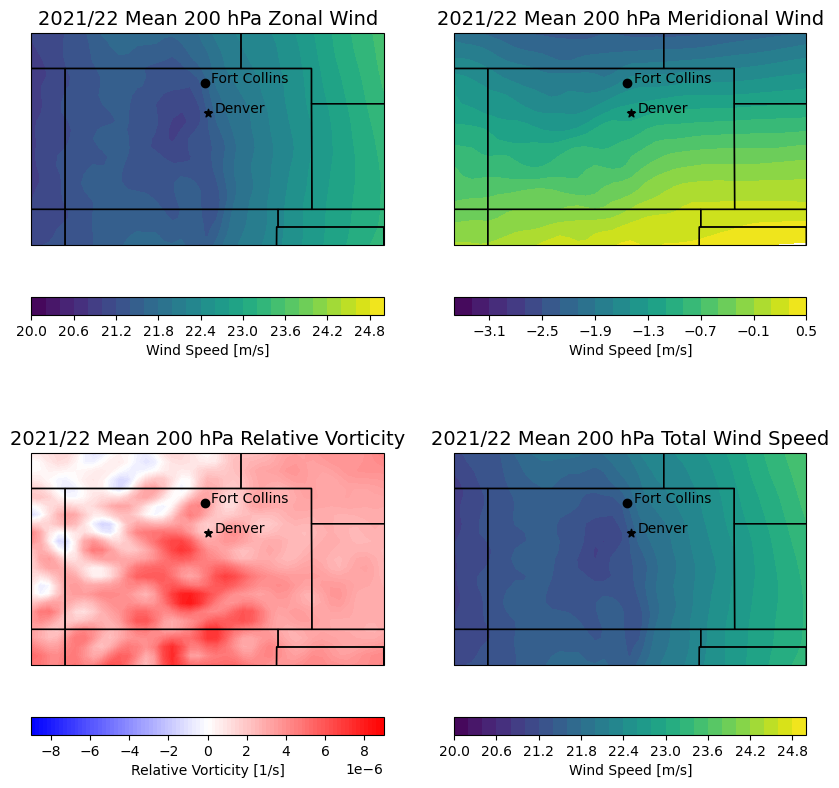

In [44]:
#make the levels for the contours
uclv = np.arange(20,25.1,0.2)
vclv = np.arange(-3.5,0.6,0.2)
vortclv = np.arange(-9.0e-6,9.1e-6,0.2e-6)
totclv = np.arange(20,25.1,0.2)

#now make the axes
fig,ax = plt.subplots(2,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (10,10))

#first let's fill in U
ax[0,0].add_feature(cfeature.STATES)
cf0 = ax[0,0].contourf(lons,lats,u_clim, levels = uclv, cmap = 'viridis')
ax[0,0].set_title('2021/22 Mean 200 hPa Zonal Wind',fontsize = 14)
plt.colorbar(cf0,orientation = 'horizontal',label = 'Wind Speed [m/s]')

#next let's fill in V
ax[0,1].add_feature(cfeature.STATES)
cf1 = ax[0,1].contourf(lons,lats,v_clim,levels = vclv, cmap = 'viridis')
ax[0,1].set_title('2021/22 Mean 200 hPa Meridional Wind',fontsize = 14)
plt.colorbar(cf1,orientation = 'horizontal', label = 'Wind Speed [m/s]')

#next let's fill in vort
ax[1,0].add_feature(cfeature.STATES)
cf2 = ax[1,0].contourf(lons,lats,vort_clim, levels = vortclv, cmap = 'bwr')
ax[1,0].set_title('2021/22 Mean 200 hPa Relative Vorticity',fontsize = 14)
plt.colorbar(cf2,orientation = 'horizontal', label = 'Relative Vorticity [1/s]')

#next let's do total wind
ax[1,1].add_feature(cfeature.STATES)
cf3 = ax[1,1].contourf(lons,lats,tot_clim,levels = totclv, cmap = 'viridis')
ax[1,1].set_title('2021/22 Mean 200 hPa Total Wind Speed',fontsize = 14)
plt.colorbar(cf3,orientation = 'horizontal', label = 'Wind Speed [m/s]')

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')

plt.show()


[ 1564 13559 11468  7689]


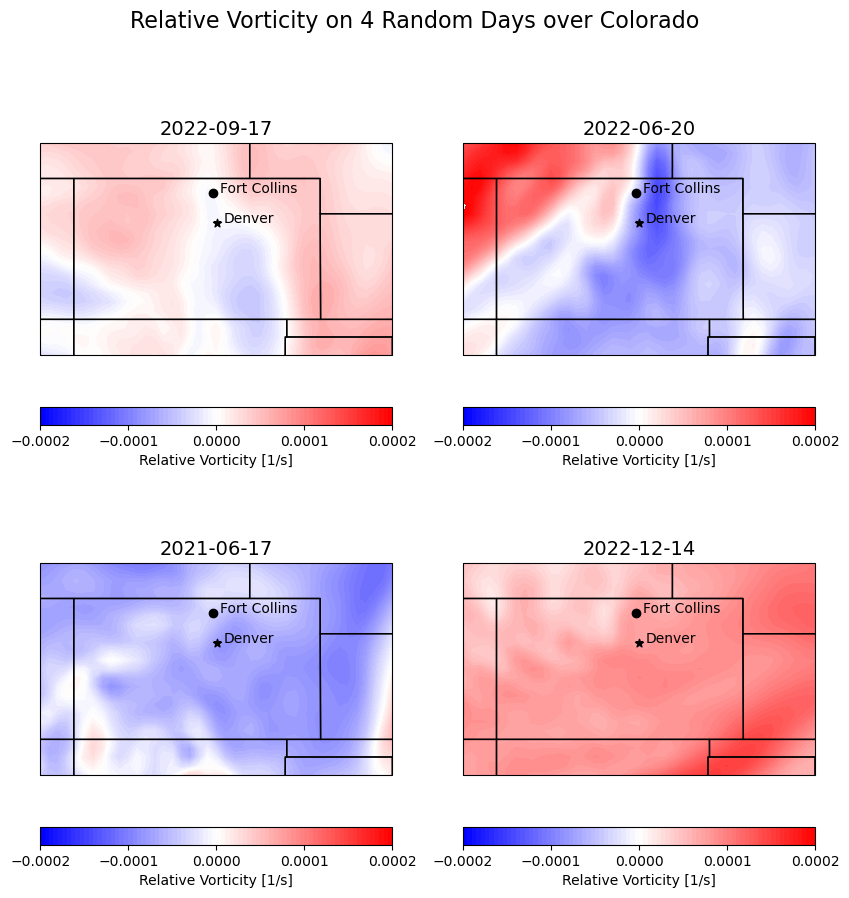

In [170]:
#make validation plots for 4 random days of the data
rng = np.random.default_rng(seed=1996)
random_days = rng.integers(1,len(time),size = 4)

#make the levels for the contours
vortclv = np.arange(-2.0e-4,2.05e-4,5e-6)
cticks = [-2e-4,-1e-4,0,1e-4,2e-4]

#now make the axes
fig,ax = plt.subplots(2,2,subplot_kw={'projection':ccrs.PlateCarree()},figsize = (10,10))

#first let's fill in U
ax[0,0].add_feature(cfeature.STATES)
cf0 = ax[0,0].contourf(lons,lats,vort[random_days[0]],levels = vortclv, cmap = 'bwr')
ax[0,0].set_title(f"{dates[random_days[0]].strftime('%Y-%m-%d')}",fontsize = 14)
plt.colorbar(cf0,orientation = 'horizontal',label = 'Relative Vorticity [1/s]',ticks = cticks)

#next let's fill in V
ax[0,1].add_feature(cfeature.STATES)
cf1 = ax[0,1].contourf(lons,lats,vort[random_days[1]],levels = vortclv, cmap = 'bwr')
ax[0,1].set_title(f"{dates[random_days[1]].strftime('%Y-%m-%d')}",fontsize = 14)
plt.colorbar(cf1,orientation = 'horizontal', label = 'Relative Vorticity [1/s]',ticks = cticks)

#next let's fill in vort
ax[1,0].add_feature(cfeature.STATES)
cf2 = ax[1,0].contourf(lons,lats,vort[random_days[2]],levels = vortclv, cmap = 'bwr')
ax[1,0].set_title(f"{dates[random_days[2]].strftime('%Y-%m-%d')}",fontsize = 14)
plt.colorbar(cf2,orientation = 'horizontal', label = 'Relative Vorticity [1/s]',ticks = cticks)

#next let's do total wind
ax[1,1].add_feature(cfeature.STATES)
cf3 = ax[1,1].contourf(lons,lats,vort[random_days[3]],levels = vortclv, cmap = 'bwr')
ax[1,1].set_title(f"{dates[random_days[3]].strftime('%Y-%m-%d')}",fontsize = 14)
plt.colorbar(cf3,orientation = 'horizontal', label = 'Relative Vorticity [1/s]',ticks = cticks)

for a in ax:
    for b in a:
        b.scatter(-104.9903,39.7392,color = 'k',marker = '*')
        b.text(-104.8,39.7392,'Denver',color = 'k')
        b.scatter(-105.0844,40.5853,color = 'k')
        b.text(-104.9,40.5853,'Fort Collins')

plt.suptitle('Relative Vorticity on 4 Random Days over Colorado', fontsize = 16)

plt.show()


In [149]:
#let's look at plots of Autocorrelation in time for each of our three variables
#first convert each variable to time series
u_time = np.nanmean(u,axis = (1,2))
v_time = np.nanmean(v,axis = (1,2))
vort_time = np.nanmean(vort,axis = (1,2))
#convert each to pandas time series
u_series = pd.Series(u_time)
v_series = pd.Series(v_time)
vort_series = pd.Series(vort_time)
#get the autocorrelation
n_lags = 365*24
u_autocorr = []
v_autocorr = []
vort_autocorr = []
for i in range(1,n_lags+1):
    u_autocorr.append(u_series.autocorr(lag = i))
    v_autocorr.append(v_series.autocorr(lag = i))
    vort_autocorr.append(vort_series.autocorr(lag = i))

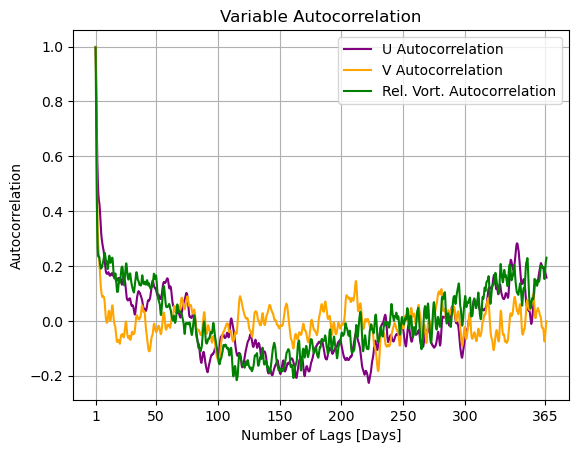

In [171]:

plt.plot(u_autocorr,color = 'purple',label = 'U Autocorrelation')
plt.plot(v_autocorr,color = 'orange', label = 'V Autocorrelation')
plt.plot(vort_autocorr, color = 'green', label = 'Rel. Vort. Autocorrelation')
plt.legend(loc = 'best')
plt.xticks([0,49*24,99*24,149*24,199*24,249*24,299*24,364*24],['1','50','100','150','200','250','300','365'],rotation = 0)
plt.ylabel('Autocorrelation')
plt.xlabel('Number of Lags [Days]')
plt.title('Variable Autocorrelation')
plt.grid()
plt.show()

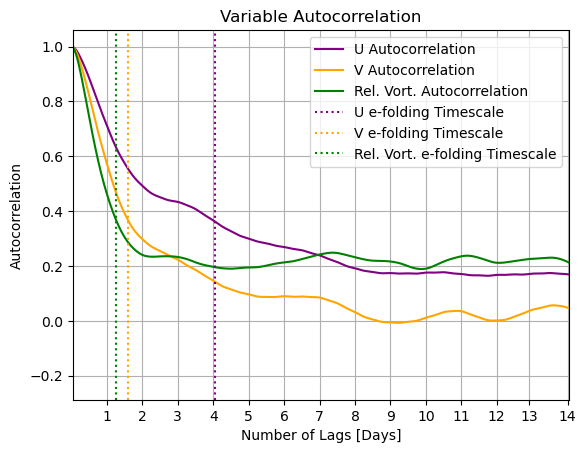

In [172]:

plt.plot(u_autocorr,color = 'purple',label = 'U Autocorrelation')
plt.plot(v_autocorr,color = 'orange', label = 'V Autocorrelation')
plt.plot(vort_autocorr, color = 'green', label = 'Rel. Vort. Autocorrelation')
plt.xticks([24-1,48-1,24*3-1,24*4-1,24*5-1,24*6-1,24*7-1,24*8-1,24*9-1,239,24*11-1,24*12-1,24*13-3,24*14-1],['1','2','3','4','5','6','7','8','9','10','11','12','13','14'],rotation = 0)
plt.ylabel('Autocorrelation')
plt.xlabel('Number of Lags [Days]')
plt.title('Variable Autocorrelation')
plt.xlim(0,24*14)
plt.axvline(96,color = 'purple', label = 'U e-folding Timescale',linestyle = ':',alpha=1)
plt.axvline(37,color = 'orange', label = 'V e-folding Timescale',linestyle = ':',alpha=1)
plt.axvline(29,color = 'green', label = 'Rel. Vort. e-folding Timescale',linestyle = ':',alpha=1)
plt.grid()
plt.legend(loc = 'best')
plt.show()